In [1]:
%matplotlib inline
morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'
from matplotlib import pyplot as plt
import numpy as np 
import h5py


In [4]:
from astropy.table import Table
mock = Table()

import os
dktdir = "/global/projecta/projectdirs/lsst/groups/CS/cosmoDC2"
dirname = os.path.join(dktdir, "cosmoDC2_v1.0.0")
basename = "z_0_1.step_all.healpix_564.hdf5"

with h5py.File(os.path.join(dirname, basename)) as f:
    mock['redshift'] = f['galaxyProperties/redshift'].value
    mock['mstar'] = f['galaxyProperties/totalMassStellar'].value

    keys_to_keep = list(
        key for key in f['galaxyProperties/LSST_filters'].keys() 
        if 'observed:dustAtlas' in key and 'magnitude' not in key)
    keys_to_keep2 = list(key for key in f['galaxyProperties/otherLuminosities'].keys() 
                            if 'Lyc' not in key)
    for key in keys_to_keep:
        mock[key] = f['galaxyProperties/LSST_filters'+'/'+key].value
    for key in keys_to_keep2:
        mock[key] = f['galaxyProperties/otherLuminosities'+'/'+key].value

for key in mock.keys():
    newkey = key.replace(':LSST', '')
    newkey = newkey.replace('LuminositiesStellar', '')
    newkey = newkey.replace('observed:dustAtlas', '')
    newkey = newkey.replace('spheroid', 'bulge')
    newkey = newkey.replace(':B:', '_B_')
    newkey = newkey.replace(':V:', '_V_')
    newkey = newkey.replace('rest:dustAtlas', 'rest_dust')
    newkey = newkey.replace(':', '')
    mock.rename_column(key, newkey)
print(mock.keys())

['redshift', 'mstar', 'disk_g', 'disk_i', 'disk_r', 'disk_u', 'disk_y', 'disk_z', 'bulge_g', 'bulge_i', 'bulge_r', 'bulge_u', 'bulge_y', 'bulge_z', 'total_g', 'total_i', 'total_r', 'total_u', 'total_y', 'total_z', 'disk_B_rest', 'disk_B_rest_dust', 'disk_V_rest', 'disk_V_rest_dust', 'bulge_B_rest', 'bulge_B_rest_dust', 'bulge_V_rest', 'bulge_V_rest_dust', 'total_B_rest', 'total_B_rest_dust', 'total_V_rest', 'total_V_rest_dust']


In [5]:
def _calc_Rv(lum_v, lum_v_dust, lum_b, lum_b_dust): #Rv definition with best behavior
    with np.errstate(divide='ignore', invalid='ignore'):
        Av = -2.5*np.log10(lum_v_dust) + 2.5*np.log10(lum_v)
        Ab = -2.5*np.log10(lum_b_dust) + 2.5*np.log10(lum_b)
        Ebv = -2.5*np.log10(lum_b_dust) + 2.5*np.log10(lum_b) - 2.5*np.log10(lum_v_dust) + 2.5*np.log10(lum_v)
        Rv = Av / Ebv
        Rv[(Av == 0) & (Ab == 0)] = 1.0
        #remove remaining nans and infs for image sims
        mask = np.isfinite(Rv)
        r = np.random.RandomState(43) # for reproduceability
        Rv[~mask] = r.uniform(1.0, 5.0, np.count_nonzero(~mask))
        return Rv


def _calc_Av(lum_v, lum_v_dust):
    with np.errstate(divide='ignore', invalid='ignore'):
        Av = -2.5*(np.log10(lum_v_dust/lum_v))
        Av[lum_v==0] = 0.
        return Av

mock['total_Rv'] = _calc_Rv(mock['total_V_rest'], mock['total_V_rest_dust'],
             mock['total_B_rest'], mock['total_B_rest_dust'])
mock['bulge_Rv'] = _calc_Rv(mock['bulge_V_rest'], mock['bulge_V_rest_dust'],
                 mock['bulge_B_rest'], mock['bulge_B_rest_dust'])
mock['disk_Rv'] = _calc_Rv(mock['disk_V_rest'], mock['disk_V_rest_dust'],
                 mock['disk_B_rest'], mock['disk_B_rest_dust'])
mock['total_Av'] = _calc_Av(mock['total_V_rest'], mock['total_V_rest_dust'])
mock['disk_Av'] = _calc_Av(mock['disk_V_rest'], mock['disk_V_rest_dust'])
mock['bulge_Av'] = _calc_Av(mock['bulge_V_rest'], mock['bulge_V_rest_dust'])


In [6]:
np.count_nonzero(mock['bulge_V_rest'] == mock['bulge_V_rest_dust']), len(mock['bulge_V_rest'])

(18986309, 31905158)

In [20]:
print(np.min(mock['total_Av']), np.count_nonzero(mock['total_Av']<0)/float(len(mock['bulge_V_rest'])))
print(np.min(mock['bulge_Av']), np.count_nonzero(mock['bulge_Av']<0)/float(len(mock['bulge_V_rest'])))
print(np.min(mock['disk_Av']), np.count_nonzero(mock['disk_Av']<0)/float(len(mock['bulge_V_rest'])))

-0.0194128 0.15160880883272856
0.0 0.0
-0.0214153 0.19388024970758647


In [5]:
z0, z1, z2, z3 = 0.35, 0.6, 0.8, 1.1
z0_mask = mock['redshift'] < z0
z1_mask = (mock['redshift'] >= z0) & (mock['redshift'] < z1)
z2_mask = (mock['redshift'] >= z1) & (mock['redshift'] < z2)
z3_mask = (mock['redshift'] >= z2) & (mock['redshift'] < z3)


In [22]:
print(np.min(mock['total_Rv']), np.count_nonzero(mock['total_Rv']<0.1)/float(len(mock['bulge_V_rest'])))
print(np.min(mock['bulge_Rv']), np.count_nonzero(mock['bulge_Rv']<0.1)/float(len(mock['bulge_V_rest'])))
print(np.min(mock['disk_Rv']), np.count_nonzero(mock['disk_Rv']<0.1)/float(len(mock['bulge_V_rest'])))

-5801.0 0.1284641812461797
0.0 0.06457516994587521
-3430.0 0.132520735361975


In [27]:
print(np.count_nonzero((mock['total_Av']>1) & (mock['total_Rv']<0.1))/float(len(mock['bulge_V_rest'])))
print(np.count_nonzero((mock['bulge_Av']>1) & (mock['bulge_Rv']<0.1))/float(len(mock['bulge_V_rest'])))
print(np.count_nonzero((mock['disk_Av']>1) & (mock['disk_Rv']<0.1))/float(len(mock['bulge_V_rest'])))

0.0
0.0
2.5074315569915057e-07


In [27]:
print(np.count_nonzero((mock['total_Av']>1) & (mock['total_Rv']>=0.1))/float(len(mock['bulge_V_rest'])))
print(np.count_nonzero((mock['bulge_Av']>1) & (mock['bulge_Rv']<0.1))/float(len(mock['bulge_V_rest'])))
print(np.count_nonzero((mock['disk_Av']>1) & (mock['disk_Rv']<0.1))/float(len(mock['bulge_V_rest'])))

0.0
0.0
2.5074315569915057e-07


In [6]:
from scipy.stats import binned_statistic
logsm_bins = np.linspace(6, 12.5, 25)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])


In [7]:
clip = 0.0

frac_av_clip_total_z0, __, __ = binned_statistic(
    np.log10(mock['mstar'][z0_mask]), mock['total_Av'][z0_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_av_clip_total_z1, __, __ = binned_statistic(
    np.log10(mock['mstar'][z1_mask]), mock['total_Av'][z1_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_av_clip_total_z2, __, __ = binned_statistic(
    np.log10(mock['mstar'][z2_mask]), mock['total_Av'][z2_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_av_clip_total_z3, __, __ = binned_statistic(
    np.log10(mock['mstar'][z3_mask]), mock['total_Av'][z3_mask]<clip, 
    statistic='mean', bins=logsm_bins)

frac_av_clip_disk_z0, __, __ = binned_statistic(
    np.log10(mock['mstar'][z0_mask]), mock['disk_Av'][z0_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_av_clip_disk_z1, __, __ = binned_statistic(
    np.log10(mock['mstar'][z1_mask]), mock['disk_Av'][z1_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_av_clip_disk_z2, __, __ = binned_statistic(
    np.log10(mock['mstar'][z2_mask]), mock['disk_Av'][z2_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_av_clip_disk_z3, __, __ = binned_statistic(
    np.log10(mock['mstar'][z3_mask]), mock['disk_Av'][z3_mask]<clip, 
    statistic='mean', bins=logsm_bins)

frac_av_clip_bulge_z0, __, __ = binned_statistic(
    np.log10(mock['mstar'][z0_mask]), mock['bulge_Av'][z0_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_av_clip_bulge_z1, __, __ = binned_statistic(
    np.log10(mock['mstar'][z1_mask]), mock['bulge_Av'][z1_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_av_clip_bulge_z2, __, __ = binned_statistic(
    np.log10(mock['mstar'][z2_mask]), mock['bulge_Av'][z2_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_av_clip_bulge_z3, __, __ = binned_statistic(
    np.log10(mock['mstar'][z3_mask]), mock['bulge_Av'][z3_mask]<clip, 
    statistic='mean', bins=logsm_bins)

_mask = (mock['total_Av'] < 0) | (mock['disk_Av'] < 0) | (mock['bulge_Av'] < 0)
frac_av_clip_all_z0, __, __ = binned_statistic(
    np.log10(mock['mstar'][z0_mask]), _mask[z0_mask], statistic='mean', bins=logsm_bins)
frac_av_clip_all_z1, __, __ = binned_statistic(
    np.log10(mock['mstar'][z1_mask]), _mask[z1_mask], statistic='mean', bins=logsm_bins)
frac_av_clip_all_z2, __, __ = binned_statistic(
    np.log10(mock['mstar'][z2_mask]), _mask[z2_mask], statistic='mean', bins=logsm_bins)
frac_av_clip_all_z3, __, __ = binned_statistic(
    np.log10(mock['mstar'][z3_mask]), _mask[z3_mask], statistic='mean', bins=logsm_bins)


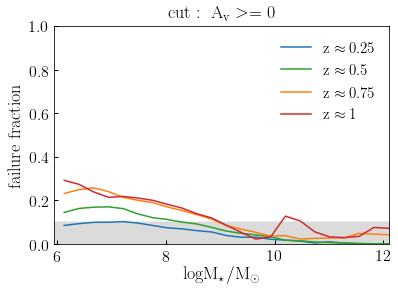

In [8]:
fig, ax = plt.subplots(1, 1)

__=ax.plot(logsm_mids, frac_av_clip_all_z0, 
           label=r'${\rm z\approx0.25}$', color=mblue)
__=ax.plot(logsm_mids, frac_av_clip_all_z1, 
           label=r'${\rm z\approx0.5}$', color=mgreen)
__=ax.plot(logsm_mids, frac_av_clip_all_z2, 
           label=r'${\rm z\approx0.75}$', color=morange)
__=ax.plot(logsm_mids, frac_av_clip_all_z3, 
           label=r'${\rm z\approx1}$', color=mred)
ylim = ax.set_ylim(0, 1)
xlim = ax.set_xlim(5.95, 12.1)

_x = np.linspace(2, 200, 1000)
_ylo = np.zeros(1000) + 0
_yhi = np.zeros(1000) + 0.1
__=ax.fill_between(_x, _ylo, _yhi, color='lightgray', alpha=0.8)

leg = ax.legend()
xlabel = ax.set_xlabel(r'${\rm log M_{\star}/M_{\odot}}$')
ylabel = ax.set_ylabel(r'${\rm failure\ fraction}$')
title = ax.set_title(r'${\rm cut:\ A_{\rm v} >= 0}$')
figname = 'av_cut_impact.png'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [9]:
clip = 0.1

frac_rv_clip_total_z0, __, __ = binned_statistic(
    np.log10(mock['mstar'][z0_mask]), mock['total_Rv'][z0_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_rv_clip_total_z1, __, __ = binned_statistic(
    np.log10(mock['mstar'][z1_mask]), mock['total_Rv'][z1_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_rv_clip_total_z2, __, __ = binned_statistic(
    np.log10(mock['mstar'][z2_mask]), mock['total_Rv'][z2_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_rv_clip_total_z3, __, __ = binned_statistic(
    np.log10(mock['mstar'][z3_mask]), mock['total_Rv'][z3_mask]<clip, 
    statistic='mean', bins=logsm_bins)

frac_rv_clip_disk_z0, __, __ = binned_statistic(
    np.log10(mock['mstar'][z0_mask]), mock['disk_Rv'][z0_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_rv_clip_disk_z1, __, __ = binned_statistic(
    np.log10(mock['mstar'][z1_mask]), mock['disk_Rv'][z1_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_rv_clip_disk_z2, __, __ = binned_statistic(
    np.log10(mock['mstar'][z2_mask]), mock['disk_Rv'][z2_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_rv_clip_disk_z3, __, __ = binned_statistic(
    np.log10(mock['mstar'][z3_mask]), mock['disk_Rv'][z3_mask]<clip, 
    statistic='mean', bins=logsm_bins)

frac_rv_clip_bulge_z0, __, __ = binned_statistic(
    np.log10(mock['mstar'][z0_mask]), mock['bulge_Rv'][z0_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_rv_clip_bulge_z1, __, __ = binned_statistic(
    np.log10(mock['mstar'][z1_mask]), mock['bulge_Rv'][z1_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_rv_clip_bulge_z2, __, __ = binned_statistic(
    np.log10(mock['mstar'][z2_mask]), mock['bulge_Rv'][z2_mask]<clip, 
    statistic='mean', bins=logsm_bins)
frac_rv_clip_bulge_z3, __, __ = binned_statistic(
    np.log10(mock['mstar'][z3_mask]), mock['bulge_Rv'][z3_mask]<clip, 
    statistic='mean', bins=logsm_bins)

_mask = (mock['total_Rv'] < 0) | (mock['disk_Rv'] < 0) | (mock['bulge_Rv'] < 0)
frac_rv_clip_all_z0, __, __ = binned_statistic(
    np.log10(mock['mstar'][z0_mask]), _mask[z0_mask], statistic='mean', bins=logsm_bins)
frac_rv_clip_all_z1, __, __ = binned_statistic(
    np.log10(mock['mstar'][z1_mask]), _mask[z1_mask], statistic='mean', bins=logsm_bins)
frac_rv_clip_all_z2, __, __ = binned_statistic(
    np.log10(mock['mstar'][z2_mask]), _mask[z2_mask], statistic='mean', bins=logsm_bins)
frac_rv_clip_all_z3, __, __ = binned_statistic(
    np.log10(mock['mstar'][z3_mask]), _mask[z3_mask], statistic='mean', bins=logsm_bins)


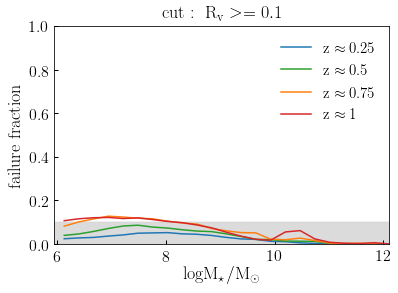

In [15]:
fig, ax = plt.subplots(1, 1)

__=ax.plot(logsm_mids, frac_rv_clip_all_z0, 
           label=r'${\rm z\approx0.25}$', color=mblue)
__=ax.plot(logsm_mids, frac_rv_clip_all_z1, 
           label=r'${\rm z\approx0.5}$', color=mgreen)
__=ax.plot(logsm_mids, frac_rv_clip_all_z2, 
           label=r'${\rm z\approx0.75}$', color=morange)
__=ax.plot(logsm_mids, frac_rv_clip_all_z3, 
           label=r'${\rm z\approx1}$', color=mred)
ylim = ax.set_ylim(0, 1)
xlim = ax.set_xlim(5.95, 12.1)

_x = np.linspace(2, 200, 1000)
_ylo = np.zeros(1000) + 0
_yhi = np.zeros(1000) + 0.1
__=ax.fill_between(_x, _ylo, _yhi, color='lightgray', alpha=0.8)

leg = ax.legend()
xlabel = ax.set_xlabel(r'${\rm log M_{\star}/M_{\odot}}$')
ylabel = ax.set_ylabel(r'${\rm failure\ fraction}$')
title = ax.set_title(r'${\rm cut:\ R_{\rm v} >= 0.1}$')
figname = 'rv_cut_impact.png'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [27]:
_mask = (mock['disk_Rv'] > 0.1) & (mock['disk_Rv'] < 1) 
_mask &= (mock['bulge_Rv'] > 0.1) & (mock['bulge_Rv'] < 1) 

_mask2 = _mask & ((mock['bulge_Av'] > 1) | (mock['disk_Av'] > 1))


tot_rv_clip_z0, __, __ = binned_statistic(
    np.log10(mock['mstar'][z0_mask]), _mask[z0_mask], 
    statistic=np.count_nonzero, bins=logsm_bins)
tot_rv_clip_av_clip_z0, __, __ = binned_statistic(
    np.log10(mock['mstar'][z0_mask]), _mask2[z0_mask], 
    statistic=np.count_nonzero, bins=logsm_bins)
frac_av_clip_z0 = tot_rv_clip_av_clip_z0/tot_rv_clip_z0.astype(float)

tot_rv_clip_z1, __, __ = binned_statistic(
    np.log10(mock['mstar'][z1_mask]), _mask[z1_mask], 
    statistic=np.count_nonzero, bins=logsm_bins)
tot_rv_clip_av_clip_z1, __, __ = binned_statistic(
    np.log10(mock['mstar'][z1_mask]), _mask2[z1_mask], 
    statistic=np.count_nonzero, bins=logsm_bins)
frac_av_clip_z1 = tot_rv_clip_av_clip_z1/tot_rv_clip_z1.astype(float)

tot_rv_clip_z2, __, __ = binned_statistic(
    np.log10(mock['mstar'][z2_mask]), _mask[z2_mask], 
    statistic=np.count_nonzero, bins=logsm_bins)
tot_rv_clip_av_clip_z2, __, __ = binned_statistic(
    np.log10(mock['mstar'][z2_mask]), _mask2[z2_mask], 
    statistic=np.count_nonzero, bins=logsm_bins)
frac_av_clip_z2 = tot_rv_clip_av_clip_z2/tot_rv_clip_z2.astype(float)

tot_rv_clip_z3, __, __ = binned_statistic(
    np.log10(mock['mstar'][z3_mask]), _mask[z3_mask], 
    statistic=np.count_nonzero, bins=logsm_bins)
tot_rv_clip_av_clip_z3, __, __ = binned_statistic(
    np.log10(mock['mstar'][z3_mask]), _mask2[z3_mask], 
    statistic=np.count_nonzero, bins=logsm_bins)
frac_av_clip_z3 = tot_rv_clip_av_clip_z3/tot_rv_clip_z3.astype(float)


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


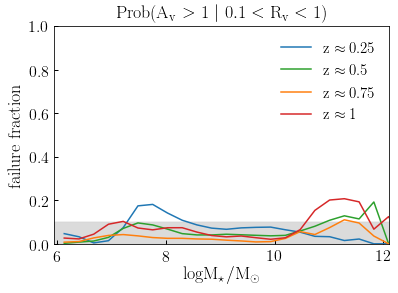

In [34]:
fig, ax = plt.subplots(1, 1)

__=ax.plot(logsm_mids, frac_av_clip_z0, 
           label=r'${\rm z\approx0.25}$', color=mblue)
__=ax.plot(logsm_mids, frac_av_clip_z1, 
           label=r'${\rm z\approx0.5}$', color=mgreen)
__=ax.plot(logsm_mids, frac_av_clip_z2, 
           label=r'${\rm z\approx0.75}$', color=morange)
__=ax.plot(logsm_mids, frac_av_clip_z3, 
           label=r'${\rm z\approx1}$', color=mred)
ylim = ax.set_ylim(0, 1)
xlim = ax.set_xlim(5.95, 12.1)

_x = np.linspace(2, 200, 1000)
_ylo = np.zeros(1000) + 0
_yhi = np.zeros(1000) + 0.1
__=ax.fill_between(_x, _ylo, _yhi, color='lightgray', alpha=0.8)

leg = ax.legend()
xlabel = ax.set_xlabel(r'${\rm log M_{\star}/M_{\odot}}$')
ylabel = ax.set_ylabel(r'${\rm failure\ fraction}$')
title = ax.set_title(r'${\rm Prob(A_v > 1\ |\ 0.1 < R_v < 1)}$')
figname = 'good_rv_av_cut_impact.png'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')